# Module 3: Supervised Learning
[Computational Genomics Chapter 5](http://compgenomr.github.io/book/supervisedLearning.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdata
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

### 3.1 How are machine learning models fitted?
* Clustering and dimension reduction techniques can use optimization methods, but they do so without having a correct answer to predict or train with. In this case, they find patterns or structure in the data without trying to estimate a correct answer.
* Machine learning models are optimization methods at their core. They all depend on defining a “cost” or “loss” function to minimize. For example, in linear regression the difference between the predicted and the original values are being minimized. When we have a data set with the correct answer such as original values or class labels, this is called supervised learning

Basic algorithm:
1. Define a prediction function or method $f(X)$.
2. Devise a function (called the loss or cost function) to optimize the difference between your predictions and observed values, such as $\sum (Y-f(X))^2$.
3. Apply mathematical optimization methods to find the best parameter values for $f(X)$ in relation to the cost/loss function.

Steps in supervised machine learning:
1. Pre-processing data: normalization & data transformation procedures
2. Training and test data split
3. Training the model: “Training" generally means your data set is used in optimization of the loss function to find parameters for $f(X)$
4. Estimating performance of the model: Deciding which metrics to use to evaluate performance and how to calculate those metrics.
5. Model tuning and selection: Try different parameters and select the best model.

### 3.2 Data preprocessing

In [2]:
# Load the cancer rna subset dataset with CpG island methylator phenotype (CIMP)
r_data = rdata.parser.parse_file("/Users/olyssa/Downloads/compGenomRData-1-2.0/inst/extdata/LGGrnaseq.rds")
as_dict = rdata.conversion.convert(r_data)
gexp = pd.DataFrame(as_dict)
gexp = gexp.set_axis(list(as_dict.dim_1.to_numpy()), axis=1)
gexp = gexp.set_axis(list(as_dict.dim_0.to_numpy()), axis=0)
gexp.head()

,TCGA-CS-4941,TCGA-CS-4944,TCGA-CS-5393,TCGA-CS-5394,TCGA-CS-5395,TCGA-CS-5396,TCGA-CS-5397,TCGA-CS-6186,TCGA-CS-6188,TCGA-CS-6669,...,TCGA-TM-A84S,TCGA-TQ-A7RI,TCGA-TQ-A7RP,TCGA-TQ-A7RR,TCGA-TQ-A8XE,TCGA-VM-A8C9,TCGA-VM-A8CD,TCGA-VM-A8CF,TCGA-VW-A8FI,TCGA-WY-A859
A1BG,72.2326,24.7132,46.3789,37.9659,19.5162,90.6419,157.9335,221.6867,174.8391,58.8621,...,104.7671,57.8723,114.1298,140.9732,114.4107,294.1675,37.9831,525.5287,149.7735,67.6466
A1CF,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4552,...,0.0000,0.4172,0.0000,0.0000,0.3660,0.0000,0.0000,0.0000,0.0000,0.0000
A2BP1,524.4997,105.4092,323.5828,19.7390,299.5375,11.0438,1646.5054,18.8235,69.8011,4608.5571,...,81.6049,174.3846,284.1710,510.7475,33.3089,125.4378,119.6291,21.9033,25.0298,2435.7939
A2LD1,144.0856,18.0154,29.0942,7.5945,202.1231,17.5750,54.2608,76.0817,71.9060,33.6413,...,30.4386,26.4622,169.0268,40.7486,26.8082,49.2200,56.2291,33.2477,91.8296,21.7057
A2ML1,521.3941,159.3746,164.6157,63.5664,953.4106,15.0318,526.5457,2173.6223,65.0995,55.5303,...,301.0314,188.9862,709.3289,467.5436,65.8858,16.5552,658.1315,172.2054,70.9178,227.7500


In [3]:
r_data = rdata.parser.parse_file("/Users/olyssa/Downloads/compGenomRData-1-2.0/inst/extdata/patient2LGGsubtypes.rds")
as_dict = rdata.conversion.convert(r_data)
patient = pd.DataFrame(as_dict)
patient.head()

,subtype
TCGA-FG-8185,CIMP
TCGA-DB-5276,CIMP
TCGA-P5-A77X,CIMP
TCGA-IK-8125,CIMP
TCGA-DU-A5TR,CIMP


#### 3.2.1 Data normalization and transformation

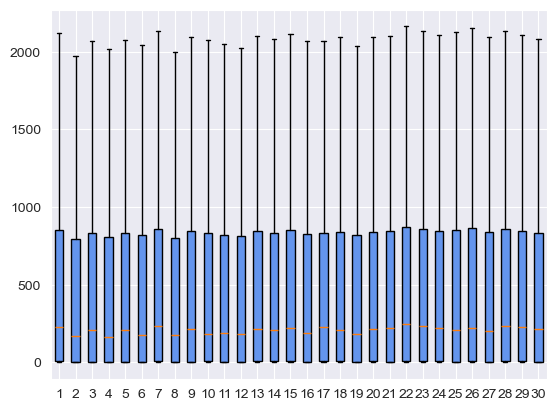

In [4]:
# Boxplots for the first 30 gene expression values

plt.boxplot(gexp.iloc[:, :30], patch_artist=True, showfliers=False, boxprops=dict(facecolor="cornflowerblue"))
plt.show()

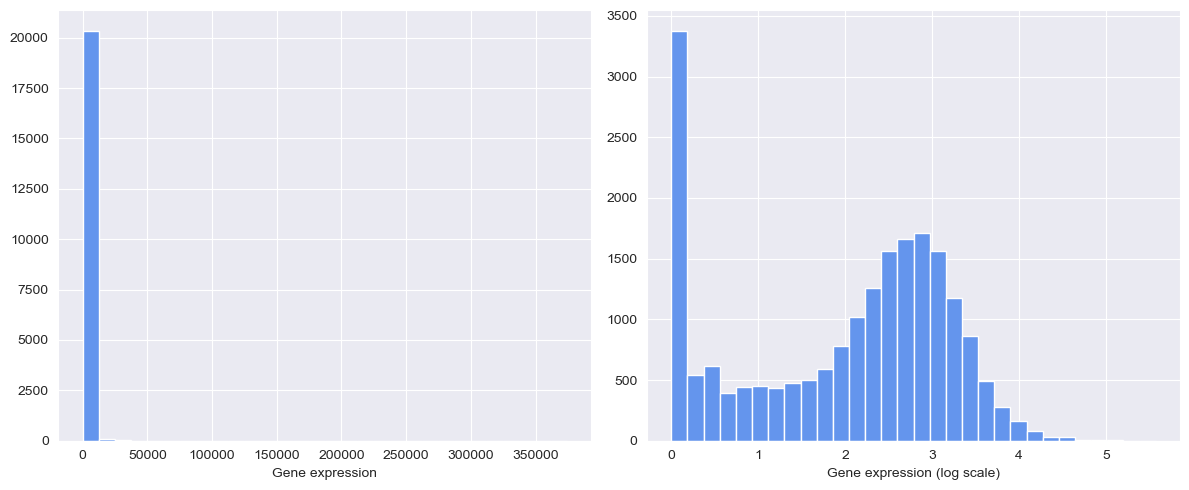

In [5]:
#  Gene expression distribution for the 5th patient (left) & Log transformed gene expression distribution for the same patient (right)

gene_expression = gexp.iloc[:, 4]  
log_gene_expression = np.log10(gexp + 1).iloc[:, 4] # taking log10 and adding pseudo-count


plt.figure(figsize=(12, 5)) 

# First histogram: Raw gene expression
plt.subplot(1, 2, 1)
plt.hist(gene_expression, bins=30, color="cornflowerblue")
plt.xlabel("Gene expression")
plt.title("")

# Second histogram: Log-transformed gene expression
plt.subplot(1, 2, 2)
plt.hist(log_gene_expression, bins=30, color="cornflowerblue")
plt.xlabel("Gene expression (log scale)")
plt.title("")

plt.tight_layout()
plt.show()

In [6]:
# Transpose data
gexp_t = gexp.T

#### 3.2.2 Data filtering and scaling

In [7]:
# Filter out near-zero features

from sklearn.feature_selection import VarianceThreshold

# Define a threshold for near-zero variance (85% of values the same)
threshold = 0.85 * (1 - 0.85)  # Variance of a binary variable with 85% identical values

# Initialize the VarianceThreshold filter
nzv_filter = VarianceThreshold(threshold=threshold)

# Apply the filter to the dataset
gexp_t_nzv = nzv_filter.fit_transform(gexp_t)

# Convert back to a pandas DataFrame
gexp_t_nzv = pd.DataFrame(gexp_t_nzv, columns=gexp_t.columns[nzv_filter.get_support()])

In [8]:
# Selecting top 1,000 features with highest standard deviations

# Calculate the standard deviation of each column
SDs = gexp_t.std(axis=0) 

# Get the indices of the top 1,000 columns with the highest standard deviation
topPreds = SDs.nlargest(1000).index

# Subset the gexp_t DataFrame to include only the top 1,000 columns
gexp_t = gexp_t[topPreds]

In [9]:
# Standardize data

from sklearn.preprocessing import StandardScaler

# Initialize the scaler with centering only (no scaling to unit variance)
scaler = StandardScaler(with_mean=True, with_std=False)

# Fit the scaler to the data and transform it
gexp_t_st = scaler.fit_transform(gexp_t)

# Convert back to a pandas DataFrame
gexp_t = pd.DataFrame(gexp_t_st, columns=gexp_t.columns)

In [10]:
# Filter out highly correlated features

# Calculate the correlation matrix
correlation_matrix = gexp_t.corr().abs()

# Identify columns to drop based on the cutoff (0.9 in this case)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Remove the highly correlated columns
gexp_t = gexp_t.drop(columns=to_drop)

#### 3.2.3 Dealing with missing values

In [11]:
# Check if there are NA values

# Create a copy of tgexp
missing_tgexp = gexp_t.copy()

# Introduce a missing value (NA equivalent in R)
missing_tgexp.iloc[0, 0] = np.nan  # Set the first row, first column to NaN

# Check if there are any missing values
any_missing = missing_tgexp.isnull().values.any()
print(any_missing) 

True


In [12]:
# Remove columns that contain any missing values

gexpnoNA = missing_tgexp.loc[:, missing_tgexp.isnull().sum(axis=0) == 0]

In [13]:
# Impute missing values

from sklearn.impute import SimpleImputer

# Create the imputer that replaces missing values with the median
imputer = SimpleImputer(strategy='median')

# Fit the imputer and transform the data
imputedGexp = pd.DataFrame(imputer.fit_transform(missing_tgexp), columns=missing_tgexp.columns)

In [14]:
from sklearn.impute import KNNImputer

# Create the KNN imputer with a specified number of neighbors (e.g., 5)
knn_imputer = KNNImputer(n_neighbors=5)

# Fit the KNN imputer and transform the data
knnimputedGexp = pd.DataFrame(knn_imputer.fit_transform(missing_tgexp), columns=missing_tgexp.columns)

### 3.3 Splitting the data

#### 3.3.1 Holdout test dataset

* Gold standard: 30 % of the data as test

In [15]:
# Merge patient and gexp_t dataframes

patient['ID'] = patient.index
gexp_t['ID'] = gexp.columns
gexp_t_merged = pd.merge(patient, gexp_t, on='ID', how='left')
gexp_t_merged.index = gexp_t_merged.index 
gexp_t_merged.head()

,subtype,ID,GFAP,CLU,TTR,SPARC,MBP,PLP1,CHI3L1,BCAN,...,KIF21B,SGK1,STAB1,CD68,MMP14,FAM84B,CSNK1E,PPP1CB,TRIO,IQSEC1
0,CIMP,TCGA-FG-8185,-370142.91494,-135127.268781,-13788.740185,-22574.170261,-57697.782656,-35291.313577,-18104.372229,105518.611502,...,-262.462664,3633.22604,-482.980513,-1687.121261,-496.074264,1667.673082,4183.386124,3980.495801,-1292.878354,-2188.459333
1,CIMP,TCGA-DB-5276,78095.84586,-43534.461981,-13783.724185,-35726.542261,110587.687744,118343.211423,-17805.603329,-7427.906898,...,-781.687764,598.79224,-562.448513,308.965439,-1337.419064,-884.621018,-876.304276,977.009901,-1614.341954,-250.736633
2,CIMP,TCGA-P5-A77X,-211127.20414,-45035.421381,-13789.641885,119925.391839,-25407.598256,-16695.529577,-18057.465329,-19912.825098,...,454.854436,-2383.42066,-1155.473413,-1900.432161,-1696.269564,-1067.854718,1523.493324,-214.219099,-814.567154,-238.921633
3,CIMP,TCGA-IK-8125,-178882.67394,-75892.719381,-13789.641885,15390.942339,-50963.870056,-23662.847177,-17846.484629,4040.711602,...,759.063336,-1253.62086,-688.490513,-1473.658461,-1569.421764,-105.317518,727.676124,-1095.651099,216.845846,419.122767
4,CIMP,TCGA-DU-A5TR,112840.34346,46411.906419,-13770.794885,-75080.222861,-20666.388356,-12088.355377,-15854.101729,3054.090002,...,-477.734364,-1613.72576,3474.958987,1770.509039,-206.968764,-1600.370318,485.332924,340.426601,-1294.462454,-1874.864233


In [16]:
# Split data into 30 % test and 70 % training

from sklearn.model_selection import train_test_split

random_seed = 3031

# Split the data into training and testing sets (70% training, 30% testing)
# The first column is the target variable (y)
training, testing = train_test_split(gexp_t_merged, 
                                     test_size=0.3, 
                                     random_state=random_seed, 
                                     stratify=gexp_t_merged.iloc[:, 0])

#### 3.3.2 Cross-validation
* When dataset is too small to set aside a significant portion of data as test a resampling-based technique like cross-validation may be useful.
* Cross-validation works by splitting the data into randomly sampled $k$ subsets, called k-folds. 
* Each time, $k-1$ of the $k$ groups are combined and used to train the model and estimate errors. 
* In that way $k$ error estimates that can be averaged to obtain a more robust estimate of the test error.
* Extreme case: $k$ is set equal to the number of data points, which is called the leave-one-out cross-validation (LOOCV).

#### 3.3.3 Bootstrap resampling
* It is used to estimate the variability of any statistical parameter.
* The training set is drawn from the original set including replacement and a model is build with the bootstrap resampled set.
*  Next, data points that are not selected for the random sample are selected and labels for them are predicted (out-of-the-bag (OOB) sample).
* This process is repeated many times (e.g. 1000 times) and errors for the OOB samples are repeated.
* The average of the OOB errors can be used to estimate the real test error.

#### 3.3.4 Training-validation-test
* This data split strategy creates three partitions of the dataset, training, validation, and test sets. 
* In this strategy, the training set is used to train the data and the validation set is used to tune the model to the best possible model. 
* The final partition, “test”, is only used for the final test and should not be used to tune the model. 
* This is regarded as the real-world prediction error for your model. 
* This strategy works when you have a lot of data to do a three-way split.

### 3.4 Predicting the subtype with k-nearest neighbors

In [17]:
training.head()

,subtype,ID,GFAP,CLU,TTR,SPARC,MBP,PLP1,CHI3L1,BCAN,...,KIF21B,SGK1,STAB1,CD68,MMP14,FAM84B,CSNK1E,PPP1CB,TRIO,IQSEC1
154,noCIMP,TCGA-HT-8110,557111.02406,-85620.501681,-13747.261785,-31628.513661,-34801.552156,-23606.675677,-10713.004129,-2385.865098,...,-636.196464,2816.51594,210.150987,5245.044139,-220.892564,-1178.484418,-2090.084476,-587.522299,-935.373754,-592.385833
140,noCIMP,TCGA-FG-A70Z,17438.83216,61023.460219,-13787.301485,-21369.069261,-46927.515756,-34679.768577,-5963.083629,28597.963202,...,-1127.028664,-304.50206,515.548987,32.060339,123.744636,-846.417418,85.279124,199.743101,-1154.912254,302.583667
118,noCIMP,TCGA-DU-8165,-284040.12904,-76192.401381,-13762.239485,-69387.494661,-44480.370256,-31068.579477,-565.358929,-54187.357898,...,-1931.574764,-1956.52426,1723.985387,307.945039,3103.842936,-1050.994718,-1329.490376,7038.227601,-1623.285454,-1292.324933
117,noCIMP,TCGA-DU-8162,-272362.63104,-104385.599081,-13789.303985,-70932.526761,47591.881644,75327.531423,-10591.073329,-51048.353698,...,627.440636,823.60264,-1094.557913,-1255.341661,-1154.568764,-1012.874318,-1606.794376,-533.857799,907.648446,3499.860767
116,noCIMP,TCGA-DU-8161,-264456.71304,295007.719119,-13789.641885,-21123.200361,-29544.848456,-21931.804477,42288.380971,-19233.512698,...,-1131.757164,632.41614,324.395587,1283.810139,-161.117564,-675.696618,-2756.415676,781.063201,-212.003154,-88.119833


In [18]:
# Predictions of training data by model trained on training data

from sklearn.neighbors import KNeighborsClassifier

# First column is the target variable
X_train = np.array(training.iloc[:, 2:])  # Features (all columns except the first and second)
y_train = np.array(training.iloc[:, 0])   # Target (the first column)

# Initialize the KNN model with k=5
knnFit = KNeighborsClassifier(n_neighbors=5)

# Train the KNN model
knnFit.fit(X_train, y_train)

# Make predictions on the training set
trainPred = knnFit.predict(X_train)

### 3.5 Assessing the performance of the model

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_train, trainPred)
print("Confusion Matrix:\n", cm)

# Classification report for more detailed metrics
print("\nClassification Report:\n", classification_report(y_train, trainPred))

Confusion Matrix:
 [[63  1]
 [12 52]]

Classification Report:
               precision    recall  f1-score   support

        CIMP       0.84      0.98      0.91        64
      noCIMP       0.98      0.81      0.89        64

    accuracy                           0.90       128
   macro avg       0.91      0.90      0.90       128
weighted avg       0.91      0.90      0.90       128


In [20]:
# Predictions of testing data by model trained on training data

# First column is the target variable
X_test = np.array(testing.iloc[:, 2:])  # Features (all columns except the first and second)
y_test = np.array(testing.iloc[:, 0])   # Target (the first column)

# Make predictions on the training set
testPred = knnFit.predict(X_test)

# Confusion matrix
cm_test = confusion_matrix(y_test, testPred)
print("Confusion Matrix (Test Set):\n", cm_test)

# Classification report for detailed metrics
print("\nClassification Report (Test Set):\n", classification_report(y_test, testPred))

Confusion Matrix (Test Set):
 [[26  2]
 [ 9 19]]

Classification Report (Test Set):
               precision    recall  f1-score   support

        CIMP       0.74      0.93      0.83        28
      noCIMP       0.90      0.68      0.78        28

    accuracy                           0.80        56
   macro avg       0.82      0.80      0.80        56
weighted avg       0.82      0.80      0.80        56


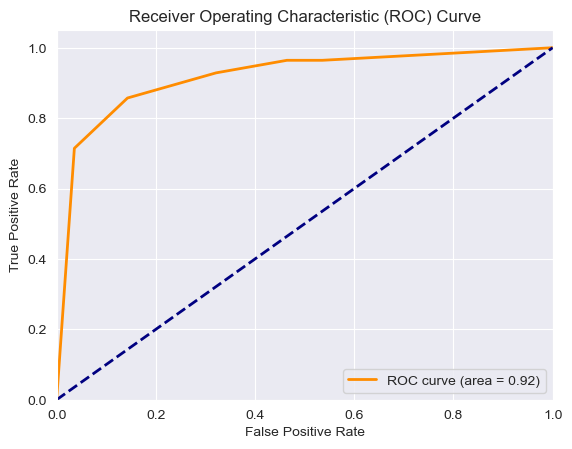

In [21]:
# Receiver Operating Characteristic (ROC) curve

from sklearn.metrics import roc_curve, roc_auc_score

# Get the probabilities for the positive class
testProbs = knnFit.predict_proba(X_test)  # Predict class probabilities

positive_class_index = 0
# Binary labels for positive class
y_test_binary = (y_test == knnFit.classes_[positive_class_index]).astype(int)  

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, testProbs[:, positive_class_index])

# Compute AUC
roc_auc = roc_auc_score(y_test_binary, testProbs[:, positive_class_index])

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 3.6 Model tuning and avoiding overfitting

In [22]:
X_train

array([[ 5.57111024e+05, -8.56205017e+04, -1.37472618e+04, ...,
        -5.87522299e+02, -9.35373754e+02, -5.92385833e+02],
       [ 1.74388322e+04,  6.10234602e+04, -1.37873015e+04, ...,
         1.99743101e+02, -1.15491225e+03,  3.02583667e+02],
       [-2.84040129e+05, -7.61924014e+04, -1.37622395e+04, ...,
         7.03822760e+03, -1.62328545e+03, -1.29232493e+03],
       ...,
       [ 7.54819448e+05,  1.00765464e+05, -1.37876585e+04, ...,
         7.64419501e+02, -2.62934295e+03, -1.71621493e+03],
       [-1.06655148e+05, -2.22234430e+04, -1.37886719e+04, ...,
        -1.53063180e+03, -1.80280765e+03,  9.58307167e+02],
       [-2.41444538e+05, -1.08432310e+05, -1.37889227e+04, ...,
        -1.49815460e+03, -5.45408854e+02, -6.11585233e+02]])

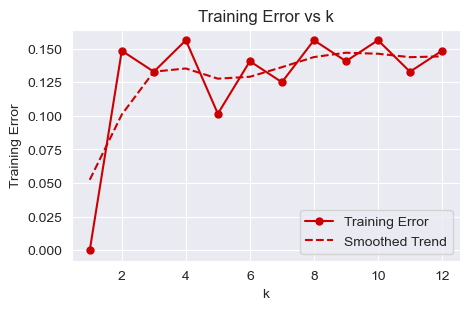

In [23]:
# Check training accuracy for different k values

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.ndimage import gaussian_filter1d

# Set the random seed
np.random.seed(101)

# Set k values
k_values = np.arange(1, 13)

# Training errors
train_err = []

X_train = training.iloc[:, 2:].values  # Features
y_train = training.iloc[:, 0].values # Class labels

for k in k_values:
    # Create the k-NN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predictions on the training set
    y_pred = knn.predict(X_train)
    
    # Calculate training error
    accuracy = accuracy_score(y_train, y_pred)
    error = 1 - accuracy
    train_err.append(error)

# Plot training error vs k
plt.figure(figsize=(5, 3))
plt.plot(k_values, train_err, 'o-', color='#CC0000', label='Training Error', markersize=5)
plt.xlabel('k')
plt.ylabel('Training Error')
plt.title('Training Error vs k')
plt.grid(True)

# Add a smooth line for the trend
smoothed_error = gaussian_filter1d(train_err, sigma=1)  # Gaussian smoothing
plt.plot(k_values, smoothed_error, color='#CC0000', linestyle='--', label='Smoothed Trend')
plt.legend()
plt.show()

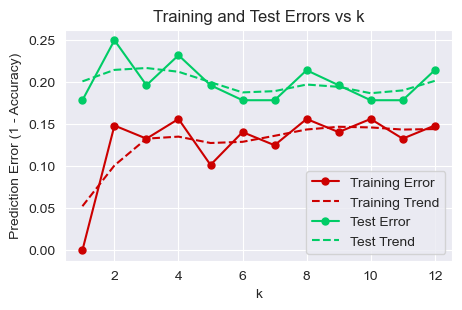

In [24]:
# Looking at training and testing data

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.ndimage import gaussian_filter1d

# Set random seed
np.random.seed(31)

# Define k values
k_values = np.arange(1, 13)

# Placeholder for errors
train_err = []
test_err = []

# Split features and labels
X_train = training.iloc[:, 2:].values
y_train = training.iloc[:, 0].values
X_test = testing.iloc[:, 2:].values
y_test = testing.iloc[:, 0].values

for k in k_values:
    # Create the k-NN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predictions on training set
    y_train_pred = knn.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_error = 1 - train_accuracy
    train_err.append(train_error)
    
    # Predictions on testing set
    y_test_pred = knn.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_error = 1 - test_accuracy
    test_err.append(test_error)

# Plot training error
plt.figure(figsize=(5, 3))
plt.plot(k_values, train_err, 'o-', color='#CC0000', label='Training Error', markersize=5)
plt.plot(k_values, gaussian_filter1d(train_err, sigma=1), '--', color='#CC0000', label='Training Trend')

# Plot test error
plt.plot(k_values, test_err, 'o-', color='#00CC66', label='Test Error', markersize=5)
plt.plot(k_values, gaussian_filter1d(test_err, sigma=1), '--', color='#00CC66', label='Test Trend')

# Formatting the plot
plt.xlabel('k')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.title('Training and Test Errors vs k')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [25]:
# Cross-validation

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score

# Set random seed
np.random.seed(17)

# Splitting the dataset into features and target
X_train = training.iloc[:, 2:].values # Features
y_train = training['subtype'].values # Target labels

# Defining the parameter grid for k values
param_grid = {'n_neighbors': np.arange(1, 13)}

# Creating the k-NN model
knn = KNeighborsClassifier()

# Setting up 10-fold cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, 
                           scoring=make_scorer(accuracy_score), 
                           cv=10, n_jobs=-1)

# Fitting the model
grid_search.fit(X_train, y_train)

# Best k value by cross-validation accuracy
best_k = grid_search.best_params_['n_neighbors']
print("Best k value:", best_k)

Best k value: 9


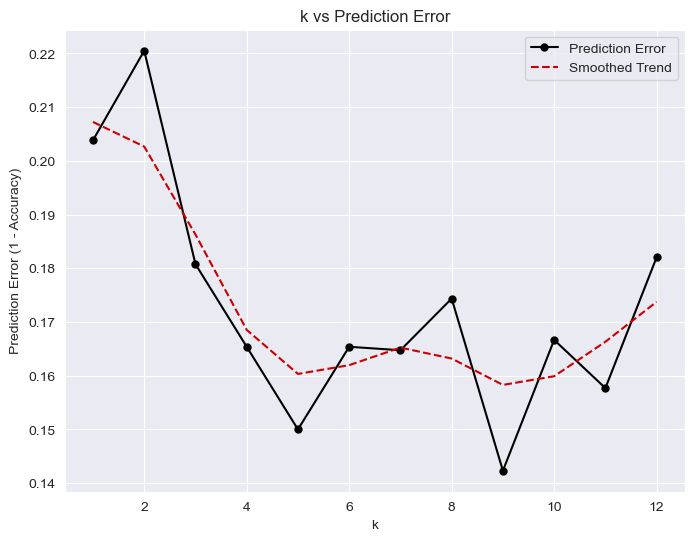

In [26]:
# Extract results from GridSearchCV
k_values = np.arange(1, 13)
accuracy_scores = grid_search.cv_results_['mean_test_score']

# Convert accuracy to prediction error
prediction_errors = 1 - accuracy_scores

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(k_values, prediction_errors, 'o-', color='black', label='Prediction Error', markersize=5)
plt.xlabel('k')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.title('k vs Prediction Error')
plt.grid(True)

# Add a smooth line for the trend
smoothed_error = gaussian_filter1d(prediction_errors, sigma=1)  # Apply smoothing
plt.plot(k_values, smoothed_error, color='#CC0000', linestyle='--', label='Smoothed Trend')

plt.legend()
plt.show()

### 3.7 Variable importance
* Another important purpose of machine learning models could be to learn which variables are more important for the prediction. This information could lead to potential biological insights or could help design better data collection methods or experiments.
* One simple method for variable importance is to correlate or apply statistical tests to test the association of the predictor variable with the response variable. Variables can be ranked based on the strength of those associations. For classification problems, ROC curves can be computed by thresholding the predictor variable, and for each variable an AUC can be computed. The variables can be ranked based on these values.
* If a variable is important for prediction, removing that variable before model training will cause a drop in performance. With this understanding, we can remove the variables one by one and train models without them and rank them by the loss of performance. The most important variables must cause the largest loss of performance.
* Variable dropout loss: Instead of removing the variables at training, variables are permuted at the test phase. The loss in prediction performance is calculated by comparing the labels/values from the original response variable to the labels/values obtained by running the permuted test data through the model.

### 3.8 How to deal with class imbalance
* Refers to differing sizes if the groups that are being classified.
* Different techniques to prevent this are:
    * Sampling for class balance:
        * Down-sampling: Build the classification model with same-sized samples of the data. 
        * Up-sampling: Adding similar data points via bootstrap sampling / Creating synthetic data via SMOTE.
    * Altering case weights: Using case weights and boosting / logistic regression-based methods has an effect comparable to up-sampling the minority class.
    * Selecting different classification score cutoffs: A prediction score cutoff minimizes the excess true positives or false positives depending on the direction of class imbalance. (e.g. using ROC curves)

### 3.9 Dealing with correlated predictors
* We can do PCA on the training data, which creates new variables removing the collinearity between them. We can then train models on these new dimensions. The downside is that it is harder to interpret these variables. They are now linear combinations of original variables. The variable importance would be harder to interpret.
* We can try variable filtering and reduce the number of correlated variables. However, this may not address the multicollinearity issue where linear combinations of variables might be correlated while they are not directly correlated themselves.
* Method-specific techniques such as regularization can decrease the effects of collinearity. Regularization, as we will see in the later chapter, is a technique that is used to prevent overfitting and it can also dampen the effects of collinearity. In addition, decision-tree-based methods could suffer less from the effects of collinearity.

### 3.10 Random forests

#### 3.10.1 Decision trees
* A decision tree is a series of filters on the predictor variables. 
* The series of filters end up in a class prediction. 
* Each filter is a binary yes/no question, which creates bifurcations in the series of filters thus leading to a treelike structure. 
* The filters are dependent on the type of predictor variables.
* Every point where we filter samples based on these questions are called “decision nodes”. 
* The tree-fitting algorithm finds the best variables at decision nodes depending on how well they split the samples into classes after the application of the decision node. 
* Decision trees handle both categorical and numeric predictor variables, they are easy to interpret, and they can deal with missing variables. 
* Despite their advantages, decision trees tend to overfit if they are grown very deep and can learn irregular patterns.
* Top down manner: They select the best variables to use in decision nodes based on how homogeneous the sample sets are after the split. 
    * Measure of homogeneity: "Gini impurity":
$$I_G(p) = \sum^K_{i=1}p_i(1-p_i) = \sum^K_{i=1}p_i - \sum^K_{i=1} p_i^2 = 1 - \sum^K_{i=1} p_i^2$$
* The "Gini impurity" calculations will be done for each potential variable and the split, and every node will be constructed based on gini impurity decrease. 
* If the variable is continuous, the cutoff value will be decided based on the best impurity.

#### 3.10.2 Trees to forests
* Random forests are devised to counter the shortcomings of decision trees. 
* They are simply ensembles of decision trees. 
* Each tree is trained with a different randomly selected part of the data with randomly selected predictor variables. 
* The goal of introducing randomness is to reduce the variance of the model, so it does not overfit, at the expense of a small increase in the bias and some loss of interpretability. 
* This strategy generally boosts the performance of the final model.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
np.random.seed(17)

# Prepare training data
X = pd.DataFrame(training.iloc[:, 2:].values) # Features
y = training['subtype'].values # Target labels

# Train random forest with no resampling and OOB estimation
rf_model = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    max_features=100,         # Equivalent to `mtry` in ranger
    min_samples_leaf=1,       # Equivalent to `min.node.size`
    oob_score=True,           # Enable OOB error calculation
    bootstrap=True,           # Ensure bootstrapping for OOB
    random_state=17
)
rf_model.fit(X, y)

# Print OOB error
oob_error = 1 - rf_model.oob_score_
print(f"OOB Error: {oob_error}")

# Calculate permutation-based feature importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    rf_model, X, y, n_repeats=10, random_state=17
)

# Display feature importance
feature_importance = perm_importance.importances_mean
for feature, importance in zip(training.iloc[:, 2:].columns, feature_importance):
    print(f"Feature: {feature}, Importance: {importance}")

OOB Error: 0.0625
Feature: GFAP, Importance: 0.0
Feature: CLU, Importance: 0.0
Feature: TTR, Importance: 0.0
Feature: SPARC, Importance: 0.0
Feature: MBP, Importance: 0.0
Feature: PLP1, Importance: 0.0
Feature: CHI3L1, Importance: 0.0
Feature: BCAN, Importance: 0.0
Feature: CRYAB, Importance: 0.0
Feature: SPARCL1, Importance: 0.0
Feature: APOE, Importance: 0.0
Feature: CST3, Importance: 0.0
Feature: AQP1, Importance: 0.0
Feature: VIM, Importance: 0.0
Feature: AQP4, Importance: 0.0
Feature: ACTB, Importance: 0.0
Feature: GLUL, Importance: 0.0
Feature: FTL, Importance: 0.0
Feature: CD74, Importance: 0.0
Feature: PTPRZ1, Importance: 0.0
Feature: ATP1A2, Importance: 0.0
Feature: SLC1A2, Importance: 0.0
Feature: SPP1, Importance: 0.0
Feature: EEF1A1, Importance: 0.0
Feature: GAPDH, Importance: 0.0
Feature: NDRG2, Importance: 0.0
Feature: NTRK2, Importance: 0.0
Feature: PEA15, Importance: 0.0
Feature: FAM107A, Importance: 0.0
Feature: OS9, Importance: 0.0
Feature: SERPINA3, Importance: 0.0
F

#### 3.10.3 Variable importance

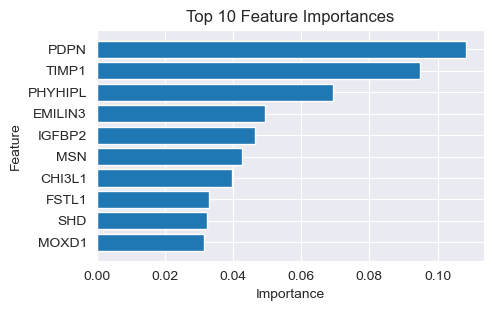

In [28]:
# Extract feature importances from the trained random forest model
feature_importances = rf_model.feature_importances_
features = training.iloc[:, 2:].columns

# Create a DataFrame for better visualization and sorting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort features by importance in descending order and select the top 10
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features
fig, ax = plt.subplots(figsize=(5, 3))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance on top
plt.show()

### 3.11 Logistic regression and regularization
* Logistic regression is a statistical method that is used to model a binary response variable based on predictor variables. 
* Although initially devised for two-class or binary response problems, this method can be generalized to multiclass problems.
* Logistic regression is very similar to linear regression as a concept, and it can be thought of as a “maximum likelihood estimation” problem where we are trying to find statistical parameters that maximize the likelihood of the observed data being sampled from the statistical distribution of interest.
* $y_i$ can only be 0 or 1, and therefore it can be realized by $p_i$ or $1-p_i$ which is why the distribution follows the Bernoulli distribution and the problem can be formulated: $p_i \sim \beta_0 + \beta_1 x_i$.
* A model that satisfies the boundary requirement is the logistic equation shown below:
$$p_i = \frac{e^{(\beta_0+\beta_1 x_i)}}{1+e^{(\beta_0+\beta_1 x_i}$$
* It can be linearized:
$$logit(p_i) = ln(\frac{p_i}{1-p_i})) = \beta_0 + \beta1 x_i$$
* Logit stands for "logistic uni" or log odds. 
* The maximum log-likelihood:
* The "log loss" function:

/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


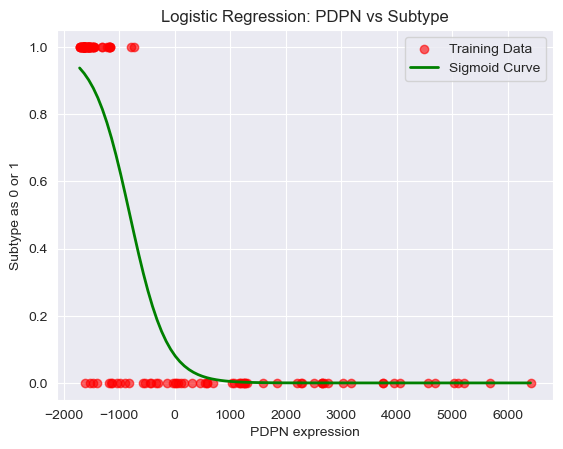

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Prepare data
X = training[['PDPN']]  # Predictor variable
y = (training['subtype'] == 'CIMP').astype(int)  # Convert subtype to binary (0 or 1)

# Fit logistic regression model
lr = LogisticRegression(solver='liblinear')  # Use 'liblinear' for binary classification
lr.fit(X, y)

# Create a range of PDPN values to plot the sigmoid curve
newdat = pd.DataFrame({'PDPN': np.linspace(X['PDPN'].min(), X['PDPN'].max(), 100)})

# Predict probabilities for the simulated data
newdat['subtype'] = lr.predict_proba(newdat[['PDPN']])[:, 1]

# Plot the training data points
plt.scatter(training['PDPN'], y, color='red', label='Training Data', alpha=0.6)

# Plot the sigmoid curve
plt.plot(newdat['PDPN'], newdat['subtype'], color='green', linewidth=2, label='Sigmoid Curve')

# Customize the plot
plt.xlabel('PDPN expression')
plt.ylabel('Subtype as 0 or 1')
plt.title('Logistic Regression: PDPN vs Subtype')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Predict class labels for the training data
class_res = lr.predict(training[['PDPN']])

# Calculate the confusion matrix
y = (training['subtype'] == 'CIMP').astype(int)  # Convert subtype to binary (0 or 1)
conf_matrix = confusion_matrix(y, class_res)

# Calculate overall accuracy
accuracy = accuracy_score(y, class_res)

print('Training:')
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")

# Predict class labels for the testing data
class_res = lr.predict(testing[['PDPN']])

# Calculate the confusion matrix
y = (testing['subtype'] == 'CIMP').astype(int)  # Convert subtype to binary (0 or 1)
conf_matrix = confusion_matrix(y, class_res)

# Calculate overall accuracy
accuracy = accuracy_score(y, class_res)

print('\nTesting:')
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")

Training:
Confusion Matrix:
[[53 11]
 [ 2 62]]
Accuracy: 0.8984375

Testing:
Confusion Matrix:
[[24  4]
 [ 1 27]]
Accuracy: 0.9107142857142857


In [31]:
# Use all genes as predictor variables

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

# Prepare data: all predictors and the target
X_train = training.iloc[:, 2:]  # All features except the target
y_train = (training['subtype'] == 'CIMP').astype(int)  # Convert target to binary

# Train logistic regression model
lr2 = LogisticRegression(solver='liblinear')  # Use 'liblinear' for small datasets or binary classification
lr2.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [32]:
# Predict on the training data
class_res_train = lr2.predict(X_train)
conf_matrix_train = confusion_matrix(y_train, class_res_train)
train_accuracy = accuracy_score(y_train, class_res_train)

print('Training:')
print(f"Confusion Matrix (Training Data):\n{conf_matrix_train}")
print(f"Training Accuracy: {train_accuracy}")

# Predict on the testing data
X_test = testing.iloc[:, 2:]  # All features except the target
y_test = (testing['subtype'] == 'CIMP').astype(int)  # Convert target to binary
class_res_test = lr2.predict(X_test)
conf_matrix_test = confusion_matrix(y_test, class_res_test)
test_accuracy = accuracy_score(y_test, class_res_test)

print('\nTesting:')
print(f"Confusion Matrix (Testing Data):\n{conf_matrix_test}")
print(f"Testing Accuracy: {test_accuracy}")

Training:
Confusion Matrix (Training Data):
[[64  0]
 [ 0 64]]
Training Accuracy: 1.0

Testing:
Confusion Matrix (Testing Data):
[[28  0]
 [ 2 26]]
Testing Accuracy: 0.9642857142857143


### 3.12 Other supervised algorithms

#### 3.12.1 Gradient boosting
* Gradient boosting is a prediction model that uses an ensemble of decision trees similar to random forest. 
* However, the decision trees are added sequentially, which is why these models are also called “Multiple Additive Regression Trees (MART)”.
* Generally, “boosting” refers to an iterative learning approach where each new model tries to focus on data points where the previous ensemble of simple models did not predict well. 
* Gradient boosting is an improvement over that, where each new model tries to focus on the residual errors (prediction error for the current ensemble of models) of the previous model. 

In [40]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Prepare data
X_train = np.array(training.iloc[:, 2:])  # All predictors
y_train = np.array((training['subtype'] == 'CIMP').astype(int))  # Convert target to binary

# Set up the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    colsample_bytree=1,
    subsample=0.5,
    gamma=0,
    min_child_weight=1,
    random_state=17
)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [200],  # Corresponds to nrounds
    'eta': [0.05, 0.1, 0.3],  # Learning rate
    'max_depth': [4]  # Tree depth
}

# Set up 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters found by cross-validation
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Best model accuracy on cross-validation
best_score = grid_search.best_score_
print(f"Best CV Accuracy: {best_score}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:31:09] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:31:09] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:31:09] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.w

Best Parameters: {'eta': 0.05, 'max_depth': 4, 'n_estimators': 200}
Best CV Accuracy: 0.9612307692307691


#### 3.12.2 Support Vector Machines
* The algorithm works by identifying the optimal decision boundary that separates the data points into different groups (or classes), and then predicts the class of new observations based on this separation boundary. 
* Depending on the situation, the different groups might be separable by a linear straight line or by a non-linear boundary line or plane.
* First, SVM can map the data to higher dimensions where the decision boundary can be linear. This is achieved by applying certain mathematical functions, called “kernel functions”, to the predictor variable space.
* Second, SVM not only tries to find a decision boundary, but tries to find the boundary with the largest buffer zone on the sides of the boundary.
* Another important feature of the algorithm is that SVM decides on the decision boundary by only relying on the “landmark” data points, formally known as “support vectors”. These are points that are closest to the decision boundary and harder to classify. By keeping track of such points only for decision boundary creation, the computational complexity of the algorithm is reduced.

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Prepare data
X_train = np.array(training.iloc[:, 2:])  # All predictors
y_train = np.array((training['subtype'] == 'CIMP').astype(int))  # Convert target to binary

# Set up the SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=17)

# Define the grid of hyperparameters to search
param_grid = {
    'C': [0.25, 0.5, 1],   # Regularization parameter
    'gamma': [1]           # Gamma corresponds to sigma in R (1 / (2*sigma^2))
}

# Set up 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters found by cross-validation
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Best model accuracy on cross-validation
best_score = grid_search.best_score_
print(f"Best CV Accuracy: {best_score}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'C': 0.25, 'gamma': 1}
Best CV Accuracy: 0.492


#### 3.12.3 Neural networks and deep versions of it

In [42]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Prepare data
X_train = np.array(training.iloc[:, 2:])  # All predictors
y_train = np.array((training['subtype'] == 'CIMP').astype(int))  # Convert target to binary

# Set up the MLPClassifier (multi-layer perceptron)
mlp_model = MLPClassifier(
    max_iter=2000,  # Maximum number of iterations for training
    random_state=17
)

# Define the grid of hyperparameters to search
param_grid = {
    'hidden_layer_sizes': [(1,), (2,)],  # Corresponds to size=1:2 in R
    'alpha': [0]  # Corresponds to decay=0 in R (regularization parameter)
}

# Set up 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters found by cross-validation
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Best model accuracy on cross-validation
best_score = grid_search.best_score_
print(f"Best CV Accuracy: {best_score}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'alpha': 0, 'hidden_layer_sizes': (1,)}
Best CV Accuracy: 0.8347692307692307


#### 3.12.4 Ensemble learning
* Ensemble learning models are combinations of different machine learning models.

In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier

# Define models
knn = KNeighborsClassifier()
enet = ElasticNet()
rf = RandomForestClassifier()

# Define training data
X_train = np.array(training.iloc[:, 2:])  # All predictors
y_train = np.array((training['subtype'] == 'CIMP').astype(int))  # Convert target to binary

# Train models
knn.fit(X_train, y_train)
enet.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Prepare data
X_test = np.array(testing.iloc[:, 2:])  # All predictors
y_test = np.array((testing['subtype'] == 'CIMP').astype(int))  # Convert target to binary

# Predict with k-NN model
knn_predictions = knn.predict(X_test)

# Predict with Elastic Net model
enet_predictions = enet.predict(X_test)

# Predict with Random Forest model
rf_predictions = rf.predict(X_test)

# Combine predictions for voting
predictions_combined = np.vstack([knn_predictions, enet_predictions, rf_predictions]).T

# Perform majority voting
voting_predictions = mode(predictions_combined, axis=1).mode.flatten().astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, voting_predictions)

# Display results
print(f"Voting Accuracy: {accuracy}")
conf_matrix = confusion_matrix(y_test, voting_predictions)
print(f"Confusion Matrix:\n{conf_matrix}")

Voting Accuracy: 0.9464285714285714
Confusion Matrix:
[[27  1]
 [ 2 26]]


/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.149e-02, tolerance: 3.200e-03
  model = cd_fast.enet_coordinate_descent(


### 3.13 Predicting continuous variables: Regression with machine learning
* Optimize the prediction error which is usually in the form of the sum of squared errors (SSE):
$$SSE = \sum(Y-f(X))^2$$

### 3.14 Exercises